### NYU ECON-GA-3001 Applied Time Series 
# Python Project: *A Comprehensive Investigation on the Long-run and Short-run Determinants of U.S. Equity Market*
## Kuanghui Shen

---

### Summary

This study aims to investigate the key factors that drive the price fluctuation of the U.S. equity market over the period of January 1992 to February 2023. Existing literature has provided plenty evidence on the associations between equity price movement and macroeconomic variables, but few jointly considers the effects outside economic fundamentals such as investor behavior. So in this study, three dimensions of factors–economy, valuation and sentiment–are included in the model to provide a more comprehensive framework in equity pricing. Using a vector error correction model, the study reveals the long-run and short-run dynamic relationships between the three dimensions and the U.S. equity market. The results show that valuation and sentiment are two important dimensions for the U.S. equity market. Timing of how these dimensions affect equity price movement is also proven to be crucial. The findings support the notion that examining the long-run and short-run determinants of financial assets through a VECM can improve strategic and tactical asset allocation performance.

---

### Steps

* Pre-modeling : (1) Data Cleaning (2) ADF Test for stationarity (3) Correlation test (4) Variable Selection
* Modeling : (5) VAR lag order selection (6) Cointegration test (7) VECM modeling (8) Diagnostics
* Model Results : (9) VECM estimation (10) Granger-causality test (11) Impulse response (12) Variance decomposition (13) out-of-sample forecasting

--- 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import select_coint_rank      
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar import vecm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

In [20]:
df = pd.read_excel("/Users/wayne/Library/CloudStorage/GoogleDrive-wayne22512878@gmail.com/My Drive/Programming/NYU Spring 2024 Time-series project (colab)/data/df.xlsx")
df.info()

# Based on existing literature, several indicators are selected as the independent variables that represent 
# each dimension of factors to explain the price movement of S&P 500 Index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    374 non-null    datetime64[ns]
 1   SPX     374 non-null    float64       
 2   PMI     374 non-null    float64       
 3   IP      374 non-null    float64       
 4   RS      374 non-null    float64       
 5   CPI     374 non-null    float64       
 6   10Y%    374 non-null    float64       
 7   EFFR    374 non-null    float64       
 8   M2      374 non-null    float64       
 9   P/E     374 non-null    float64       
 10  P/B     374 non-null    float64       
 11  P/S     374 non-null    float64       
 12  VIX     374 non-null    float64       
 13  CS      350 non-null    float64       
 14  VOL     374 non-null    int64         
 15  CFTC    306 non-null    float64       
dtypes: datetime64[ns](1), float64(14), int64(1)
memory usage: 46.9 KB


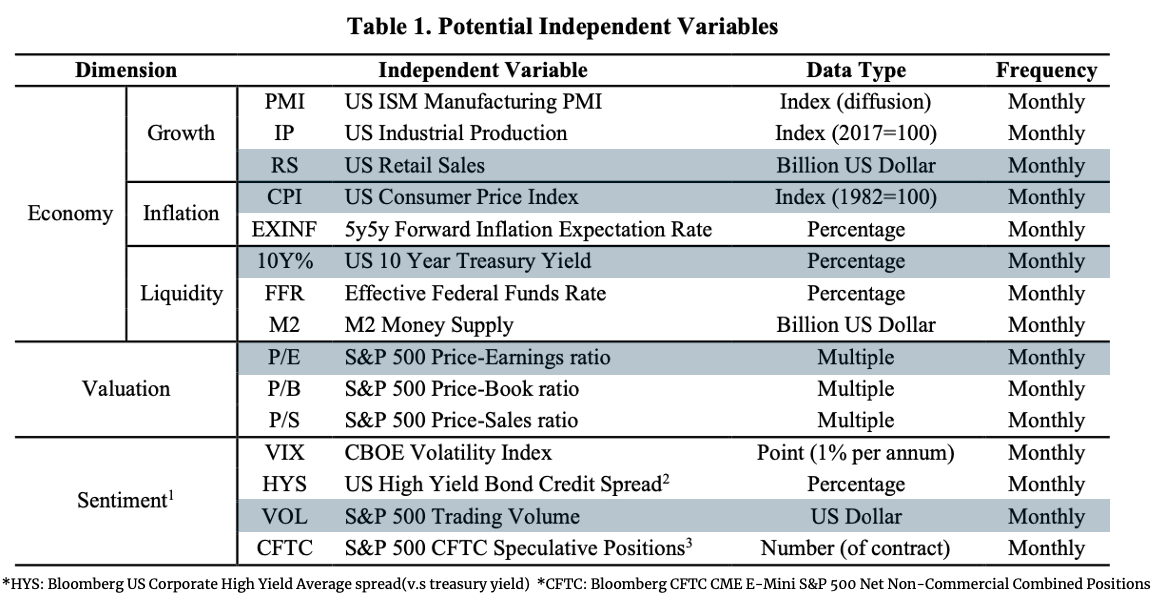

In [3]:
notna_df = df.iloc[df.notna().all(axis=1).idxmax():,:]
notna_df

,date,SPX,PMI,IP,RS,CPI,10Y%,EFFR,M2,P/E,P/B,P/S,VIX,CS,VOL,CFTC
68,1997-09-30,947.2800,53.9,82.0380,230.312,161.200,6.1030,5.54,3973.1001,21.8770,3.8278,1.5271,22.91,2.35,9040000000,116.0
69,1997-10-31,914.6200,56.4,82.7657,229.836,161.500,5.8310,5.50,3992.3000,21.1212,3.7229,1.4861,35.09,2.39,11909999616,6260.0
70,1997-11-30,955.4000,55.7,83.4321,230.440,161.700,5.8740,5.52,4014.8000,21.6209,3.7968,1.5676,27.43,2.66,8390000128,9964.0
71,1997-12-31,970.4300,54.5,83.7826,231.181,161.800,5.7420,5.50,4032.8999,21.9900,3.8568,1.5566,24.01,2.88,9880000512,11540.0
72,1998-01-31,980.2800,53.8,84.1656,231.587,162.000,5.5050,5.56,4056.2000,22.2219,3.9014,1.5745,21.47,2.92,10449999872,-2710.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,2022-10-31,3871.9800,50.0,103.3696,691.844,297.987,4.0478,3.08,21424.4004,18.5582,3.9215,2.3155,25.88,4.64,15280000000,-197860.0
370,2022-11-30,4080.1101,49.0,103.0258,684.411,298.598,3.6054,3.78,21376.5996,19.2523,4.1482,2.3687,20.58,4.48,14129999872,-154452.0
371,2022-12-31,3839.5000,48.4,101.6086,678.815,298.990,3.8748,4.10,21325.1992,18.1686,3.9058,2.2291,21.67,4.69,14499999744,-152345.0
372,2023-01-31,4076.6001,47.4,102.0205,700.682,300.536,3.5069,4.33,21183.5000,19.2915,4.1470,2.3664,19.40,4.20,13080000512,-187229.0


In [29]:
## ADF test

def ADF_test(col_list):
    for col in col_list:
        col_diff = notna_df[col].diff().dropna()
        results = {}
        
        for reg_type in ['n', 'c', 'ct']:
        # “n” : no constant, no trend 
        # “c” : constant only (default) 
        # “ct” : constant and trend
            test_level = adfuller(notna_df[col], autolag='AIC', regression=reg_type)
            test_diff = adfuller(col_diff, autolag='AIC', regression=reg_type)
            
            results[reg_type] = {'level': test_level[1],'diff': test_diff[1]}
            print(f'ADF Statistic({reg_type}) p-value: [level]{test_level[1]}; [diff]{test_diff[1]}')

        p_values_level = [results[reg_type]['level'] for reg_type in ['n', 'c', 'ct']]
        p_values_diff = [results[reg_type]['diff'] for reg_type in ['n', 'c', 'ct']]

        if all(p_val < 0.05 for p_val in p_values_level):
            print(f'=> "{col}" series is I(0)')
        elif any(p_val < 0.05 for p_val in p_values_level) and any(p_val > 0.05 for p_val in p_values_level):
            print(f'=> "{col}" series is mixed I(0)')
        elif any(p_val > 0.05 for p_val in p_values_level) and any(p_val < 0.05 for p_val in p_values_diff):
            print(f'=> "{col}" series is I(1)')
        else:
            print(f'=> "{col}" series is I(2) or above')
        
        print()
        
cols = list(notna_df.drop('date', axis=1).columns)
ADF_test(cols)

# Test results
    # I(0): CFTC
    # mixed I(0): PMI, IP, VIX, CS
    # I(1): SPX, RS, CPI, 10Y%, EFFR, M2, P/E, P/B, P/S, volume => eligible for VECM modeling

ADF Statistic(n) p-value: [level]0.9992453163788699; [diff]3.0106845867902458e-05
ADF Statistic(c) p-value: [level]0.9981947879048227; [diff]4.343445574646314e-06
ADF Statistic(ct) p-value: [level]0.9893373149004238; [diff]3.4407668319379075e-06
=> "SPX" series is I(1)

ADF Statistic(n) p-value: [level]0.5027212990288215; [diff]4.146695842294291e-28
ADF Statistic(c) p-value: [level]0.0003132019594370496; [diff]2.626879263364206e-29
ADF Statistic(ct) p-value: [level]0.001278307238581673; [diff]0.0
=> "PMI" series is mixed I(0)

ADF Statistic(n) p-value: [level]0.8849868532116159; [diff]1.1313084648295362e-23
ADF Statistic(c) p-value: [level]0.1472912641906154; [diff]2.466511027188297e-24
ADF Statistic(ct) p-value: [level]0.01571680031091663; [diff]1.287217148503883e-20
=> "IP" series is mixed I(0)

ADF Statistic(n) p-value: [level]0.9996194436054064; [diff]0.000507486622291344
ADF Statistic(c) p-value: [level]0.9970078207202372; [diff]0.0003538786042739811
ADF Statistic(ct) p-value: [le

In [25]:
##Correlation test

fig, ax = plt.subplots(figsize=(14, 7))
sn.heatmap(df.drop('date',axis=1).corr(), annot=True, fmt=".2f",vmax=1,vmin=-1)
plt.title('Cross-Variable Correlations')
plt.show()

,SPX,PMI,IP,RS,CPI,10Y%,EFFR,M2,P/E,P/B,P/S,VIX,CS,VOL,CFTC
SPX,1.000000,0.264405,0.671992,0.939347,0.878969,-0.692126,-0.410903,0.955133,0.135877,0.491163,0.901491,0.043667,-0.204914,-0.063903,0.100525
PMI,0.264405,1.000000,0.130330,0.216994,0.172046,-0.066753,-0.174644,0.222445,0.237294,0.163081,0.324619,-0.394701,-0.624394,-0.273584,0.087192
IP,0.671992,0.130330,1.000000,0.801240,0.820139,-0.758581,-0.451216,0.674739,-0.314613,0.180001,0.633660,0.087783,0.025228,0.415151,-0.077991
RS,0.939347,0.216994,0.801240,1.000000,0.981871,-0.819791,-0.577224,0.976342,-0.142229,0.224514,0.757502,0.061534,-0.075609,0.046948,0.046478
CPI,0.878969,0.172046,0.820139,0.981871,1.000000,-0.878858,-0.659322,0.955745,-0.253829,0.093110,0.668202,0.092748,0.018341,0.060683,0.055593
10Y%,-0.692126,-0.066753,-0.758581,-0.819791,-0.878858,1.000000,0.818545,-0.807842,0.265956,0.069164,-0.519946,-0.148995,-0.191923,-0.109047,-0.118078
EFFR,-0.410903,-0.174644,-0.451216,-0.577224,-0.659322,0.818545,1.000000,-0.600679,0.240524,0.366443,-0.197322,-0.106194,-0.293082,-0.037531,-0.193479
M2,0.955133,0.222445,0.674739,0.976342,0.955745,-0.807842,-0.600679,1.000000,-0.051161,0.235553,0.756733,0.077871,-0.073987,-0.084847,0.092438
P/E,0.135877,0.237294,-0.314613,-0.142229,-0.253829,0.265956,0.240524,-0.051161,1.000000,0.652765,0.375954,-0.075589,-0.256907,-0.196086,0.176505
P/B,0.491163,0.163081,0.180001,0.224514,0.093110,0.069164,0.366443,0.235553,0.652765,1.000000,0.767402,0.078272,-0.338191,-0.002478,0.078551


In [ ]:
## Variable Selection
    # to mitigate multicollinearity, independent variables are narrowed down to five: (1)RS (2)CPI (3)10Y% (4)P/E (5)VOL
    # the main consideration in variable selection is to filter out those that are not integrated of order 1 (for VECM)
    # the remaining variables were selected based on the fitness/correlation to the S&P 500 Index

In [30]:
tt = df.set_index("date")
tt.drop(["PMI","IP","EFFR","M2","P/B","P/S","VIX","CS","CFTC"],axis=1, inplace=True)
tt = tt.dropna()
tt.describe()

# This is a monthly dataset from January 1992 to February 2023 of the US, with 374 observations and 6 columns
# The mean and std deviation across variables differ greatly due to different units and different data types
# => log-transformation is conducted to address skewness towards large values to better fit the model

,SPX,RS,CPI,10Y%,P/E,VOL
count,374.000000,374.000000,374.000000,374.000000,374.000000,3.740000e+02
mean,1593.017115,360.640115,205.736179,3.970622,20.044602,1.669701e+10
std,998.640801,128.168320,41.277248,1.810402,4.575148,9.262057e+09
min,403.690000,163.721000,138.300000,0.528200,10.646400,2.560000e+09
25%,975.945000,262.604750,168.175000,2.393675,16.703875,1.078250e+10
50%,1284.475000,354.307500,207.635000,3.928800,19.044350,1.394000e+10
75%,2055.159900,442.872000,237.472750,5.463000,22.192750,2.447500e+10
max,4766.180200,700.682000,301.648000,7.906000,34.358900,4.684000e+10


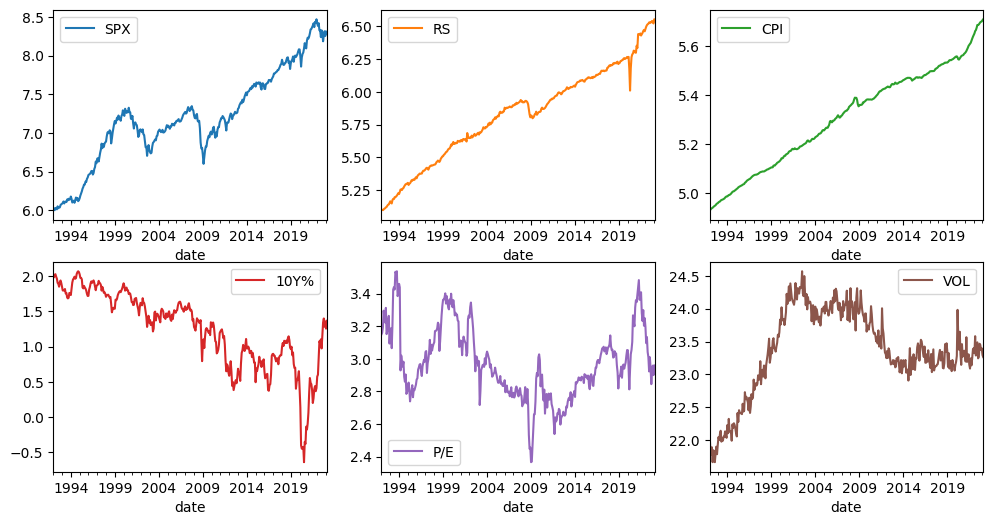

In [9]:
tt_log = tt.applymap(lambda x: np.log(x))
tt_log.plot(subplots=True, layout=(2, 3), figsize=(12, 6), sharex=False)
plt.show()

# the time series plot shows that the data property of the first four variables are with drift and trend; 
# the last two, P/E and VOL, might be with only constant only or with trend
# => this would help us identify the regression method in ADF test, Johansen test and VECM modeling

In [11]:
## Lag order selection

tt_level_VAR = VAR(tt_log)
lag_order = tt_level_VAR.select_order(maxlags=12,trend='ct') #ct: constant and linear term
print(lag_order.summary())
print(lag_order.aic, lag_order.bic, lag_order.fpe, lag_order.hqic)

# => select VAR(3) lag order 3 for further modeling

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -25.88      -25.75   5.777e-12      -25.83
1       -41.16      -40.64   1.336e-18      -40.95
2       -41.65     -40.75*   8.164e-19     -41.29*
3      -41.80*      -40.51  7.008e-19*      -41.29
4       -41.75      -40.07   7.389e-19      -41.08
5       -41.73      -39.67   7.559e-19      -40.91
6       -41.73      -39.28   7.589e-19      -40.75
7       -41.67      -38.84   8.026e-19      -40.55
8       -41.59      -38.37   8.737e-19      -40.31
9       -41.52      -37.91   9.397e-19      -40.09
10      -41.42      -37.42   1.053e-18      -39.83
11      -41.37      -36.99   1.107e-18      -39.63
12      -41.45      -36.68   1.029e-18      -39.56
--------------------------------------------------
3 2 3 2


In [12]:
##Cointegration test

methods = ['trace', 'maxeig']
for method in methods:
    coint_rank = select_coint_rank(
        tt_log, # run cointegration test in "level"
        0,      # "constant term" as input for "det_order"
        2,      # "number of lagged differences" = lag order(VAR) - 1 = 2
        method=method, 
        signif=0.05   
    )
    print(coint_rank.summary(),'\n')

# => both trace test and maximum eigenvalue test suggest 2 cointegration (rank 2)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   6          129.4          95.75
  1   6          77.51          69.82
  2   6          43.33          47.85
------------------------------------- 

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          51.90          40.08
  1   2          34.18          33.88
  2   3          18.88          27.59
------------------------------------- 



In [13]:
##VECM modeling

model = vecm.VECM(
    tt_log,              # run cointegration test in "level"
    deterministic="co",  # data type = constant outside the cointegration relation
    freq = "M",          # data frequency = monthly
    k_ar_diff = 2,       # "number of lagged differences" = lag order(VAR) - 1 = 2
    coint_rank=2         # cointegration rank = 2 from Johansen test
)
VECM_model = model.fit()
print(VECM_model.summary())

# ECM1 shows that there is a long-run equilibrium relationship between S&P 500, Inflation, P/E ratio and volume 
# => inflation, valuation and sentiment have positive impact on S&P 500 in the long run

# ECM2 shows that in the short run, the lag one month of retail sales is positively associated with S&P 500
# and that lag two months of P/E ratio presents a negative influence on S&P 500
# the coefficient of ECM2 is significant at -0.146, implying a 14.6% correction from deviation in 1 month

Det. terms outside the coint. relation & lagged endog. parameters for equation SPX
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0216      0.182     -0.118      0.906      -0.379       0.336
L1.SPX         0.0301      0.073      0.410      0.682      -0.114       0.174
L1.RS          0.2622      0.145      1.809      0.070      -0.022       0.546
L1.CPI        -0.5520      1.011     -0.546      0.585      -2.534       1.430
L1.10Y%       -0.0168      0.026     -0.637      0.524      -0.069       0.035
L1.P/E        -0.0467      0.047     -0.991      0.322      -0.139       0.046
L1.VOL         0.0003      0.016      0.017      0.986      -0.031       0.031
L2.SPX         0.0193      0.075      0.258      0.796      -0.127       0.166
L2.RS          0.1090      0.136      0.802      0.422      -0.157       0.375
L2.CPI         0.8501      0.979      0.868     

![alt text](VECM_ECMs.png)
![alt text](VECM_lr_effect.png)
![alt text](VECM_sr_effect.png)

In [14]:
##Diagnostics

# all eigenvalues are < 1 => stable VECM
print('Eigenvalues Stability test:', coint_johansen(tt_log, 0, 2).eig, '\n')

# Jarque-Bera Normality Test H0 rejected => errors are not normally distributed 
print(VECM_model.test_normality().summary(),'\n')

# Portmanteau test H0 rejected => serial correlation exists in errors
print(VECM_model.test_whiteness(nlags=12, adjusted=True).summary())

Eigenvalues Stability test: [1.30547775e-01 8.80059246e-02 4.96237456e-02 4.02398858e-02
 2.45130194e-02 1.73112635e-05] 

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
     2.046e+04          21.03   0.000 12
---------------------------------------- 

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 12 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         488.1          392.5   0.000 348
-----------------------------------------


In [15]:
##Granger-Causality test

cols = list(tt_log.columns)
col_in_cols = {}
for col in list(tt_log.columns):
    col_in_cols[col] = cols[:cols.index(col)] + cols[cols.index(col) + 1:]
    print()
    for col_col in col_in_cols[col]:
        pvalues = VECM_model.test_granger_causality(caused=col, causing=col_col, signif=0.05).pvalue
        if pvalues < 0.05:
            print(f'{col} <- {col_col} pvalue: {pvalues} => granger causality')
        else:
            print(f'{col} <- {col_col} pvalue: {pvalues}')


SPX <- RS pvalue: 0.5390977349740842
SPX <- CPI pvalue: 0.6120485420255934
SPX <- 10Y% pvalue: 0.4225272779302217
SPX <- P/E pvalue: 0.10234604516361231
SPX <- VOL pvalue: 0.4811701576025349

RS <- SPX pvalue: 0.00011056523532441255 => granger causality
RS <- CPI pvalue: 0.19694781334540795
RS <- 10Y% pvalue: 2.437627282979045e-05 => granger causality
RS <- P/E pvalue: 0.4190918116921324
RS <- VOL pvalue: 0.0024612954990111246 => granger causality

CPI <- SPX pvalue: 0.03836971439482065 => granger causality
CPI <- RS pvalue: 0.10039871660328359
CPI <- 10Y% pvalue: 0.15681165573492528
CPI <- P/E pvalue: 0.9998490263782869
CPI <- VOL pvalue: 0.0025008137727681656 => granger causality

10Y% <- SPX pvalue: 0.01727995313686684 => granger causality
10Y% <- RS pvalue: 0.17000267349373188
10Y% <- CPI pvalue: 0.41956161103742107
10Y% <- P/E pvalue: 0.4619364701374835
10Y% <- VOL pvalue: 0.7962153985815459

P/E <- SPX pvalue: 0.04774488165362843 => granger causality
P/E <- RS pvalue: 0.44629813

![alt text](granger_causality.png)

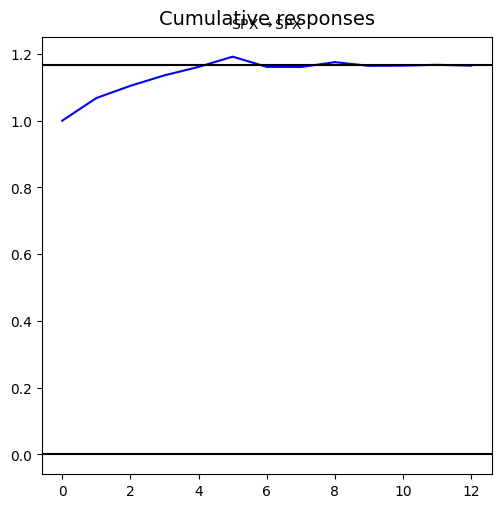

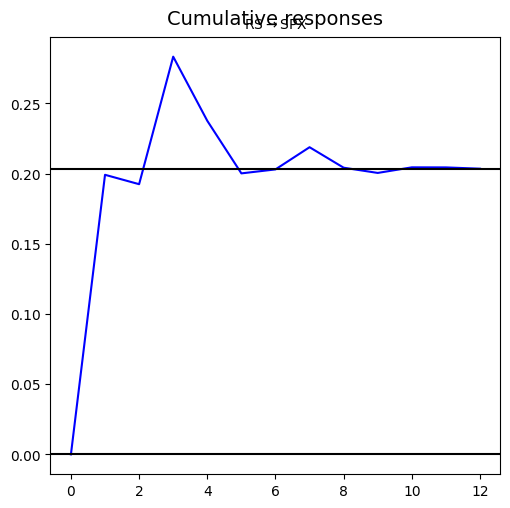

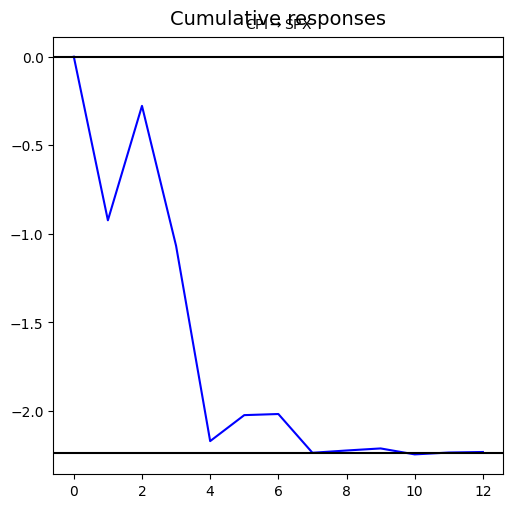

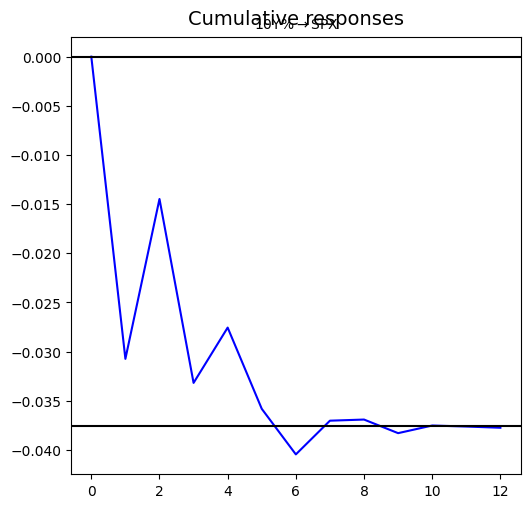

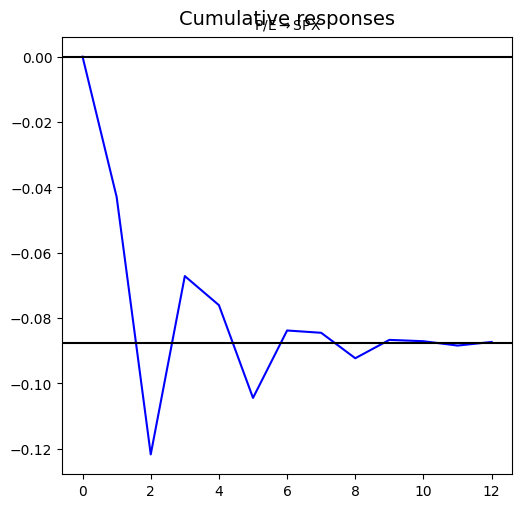

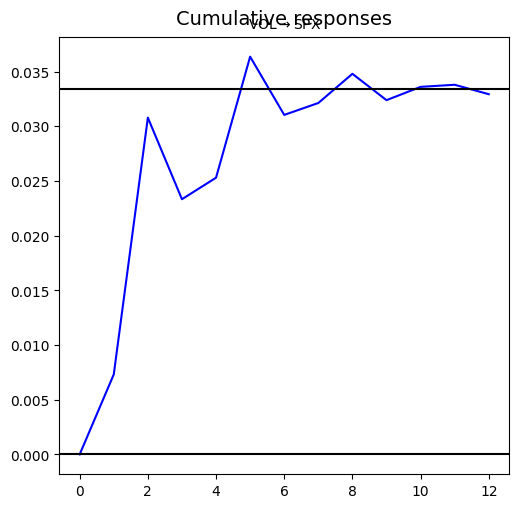

In [16]:
##Impulse Response

tt_log_diff = tt_log.diff().dropna()

VAR_model = VAR(tt_log_diff).fit(3)
irf = VAR_model.irf(12)

for col in list(tt_log_diff.columns):
    irf.plot_cum_effects(response="SPX", impulse=col, figsize=(5, 5), plot_stderr=False, subplot_params = {'fontsize' : 10})
    
# S&P 500 impulse responses support the VECM’s short-run estimations of positive RS effect and negative P/E
# other relationships are in line with classic economic and finance theories, where SPX(+) itself has a positive 
# response, CPI(-) negative , 10Y%(-) also negative, and VOL(+) is positive due to momentum effect

# another thing to notice is the duration of the impulse responses : (1) all the effects fade at around 6 months 
# after the initial shock,(2) but the durations of the main impacts are different: (2-3m)RS, P/E ; (4m)SPX, CPI ; 
# (6m)10Y%, VOL=> this result gives us an idea of the timing of how each factor impacts equity prices

![alt text](impluse_response.png)

In [17]:
##Variance Decomposition

VAR_VD = VAR_model.fevd(13)
VAR_VD.summary()

# S&P 500 variation of S&P 500 is mainly explained by its past prices (95%) while other five factors explain 5%
# among the five variables, P/E has the strongest explanatory power on SPX, beating the three macro variables

FEVD for SPX
           SPX        RS       CPI      10Y%       P/E       VOL
0     1.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1     0.987145  0.002418  0.003961  0.003851  0.002150  0.000476
2     0.973278  0.002490  0.004947  0.004509  0.009484  0.005291
3     0.966500  0.002708  0.006772  0.005640  0.012684  0.005696
4     0.962610  0.003617  0.009620  0.005726  0.012722  0.005705
5     0.960171  0.003805  0.009596  0.006041  0.013647  0.006739
6     0.959411  0.003802  0.009588  0.006098  0.014125  0.006976
7     0.959260  0.003813  0.009681  0.006138  0.014124  0.006985
8     0.959109  0.003838  0.009679  0.006137  0.014192  0.007045
9     0.959018  0.003840  0.009678  0.006141  0.014229  0.007094
10    0.959001  0.003841  0.009680  0.006142  0.014229  0.007106
11    0.958998  0.003841  0.009681  0.006142  0.014231  0.007107
12    0.958991  0.003841  0.009681  0.006142  0.014232  0.007113

FEVD for RS
           SPX        RS       CPI      10Y%       P/E       VOL

![alt text](variance_decomposition.png)

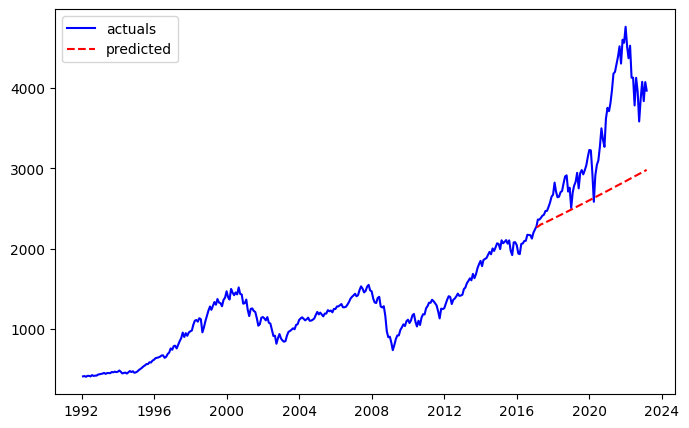

MAE: 685.801629
MSE: 751188.876265
RMSE: 866.711530


In [18]:
## Forecasting
train, test = tt_log[:300], tt_log[300:] #80% training set and 20% test set
model_train = vecm.VECM(train, deterministic="ci", k_ar_diff = 2, coint_rank=2)
VECM_model_train = model_train.fit()
pred = VECM_model_train.predict(steps=74)
pred = pd.DataFrame(pred, index=test.index, columns=test.columns+"_pred")

#Invert transformation: back to level
pred_level = np.exp(pred)
test_level = np.exp(test)
train_level = np.exp(train)
train_test_level = pd.concat([train_level, test_level],axis=0)

#forecast result
plt.figure(figsize=(8,5))
plt.plot(train_test_level["SPX"], color="blue",label="actuals")
plt.plot(pred_level["SPX_pred"],'m--', color="red",label="predicted")
plt.legend()
plt.show()

mae = mean_absolute_error(test_level['SPX'],pred_level["SPX_pred"])
print('MAE: %f' % mae)
mse = mean_squared_error(test_level['SPX'], pred_level["SPX_pred"])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

![alt text](forecasting.png)